# **Optical Character Recognition of Handwritten Digits**


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from keras.datasets import mnist
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

###**Pre-processing the MNIST dataset**

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


**Scaling**

In [ ]:
x_train = x_train / 255.
x_test = x_test / 255.

**Deskewing**

In [ ]:
# https://fsix.github.io/mnist/Deskewing.html
# https://stackoverflow.com/questions/43577665/deskew-mnist-images

from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

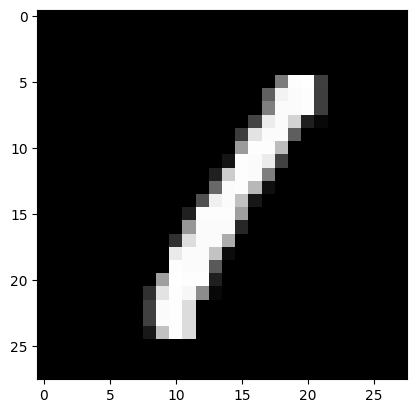

In [ ]:
plt.imshow(x_train[3], cmap = 'gray')
plt.show()

In [ ]:
for i in range(len(x_train)):
  x_train[i] = deskew(x_train[i])
for i in range(len(x_test)):
  x_test[i] = deskew(x_test[i])

<ipython-input-6-935e80f76932>:24: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  img = interpolation.affine_transform(image,affine,offset=offset)


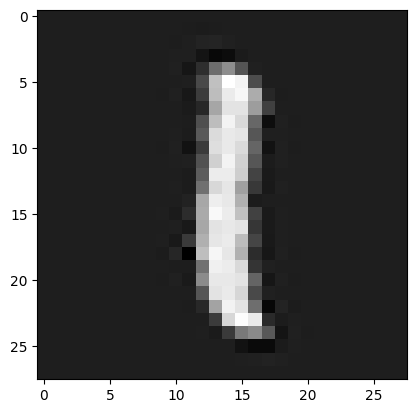

In [ ]:
plt.imshow(x_train[3], cmap = 'gray')
plt.show()

**Reshaping**

In [ ]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

###**K-Nearest Neighbors (KNN)**


In [ ]:
# image : 784-dimensional vector
# k : (expects) a positive integer that represents the number of nearest neighbors
# graph : boolean that represents whether or not the user wants a histogram of the k-nearest neighbors. returns nothing if true
# outputs the algorithm prediction (integer)
def k_nearest_neighbors(image, k, graph=False):
  distances = np.array([])

  for im in x_train:
    distances = np.append(distances, np.linalg.norm(im-image))

  sorted_indices = np.argsort(distances)[:k]
  nearest_images = y_train[sorted_indices]

  if graph:
    plt.hist(nearest_images, range=(0,10))
    plt.ylabel('Frequency')
    plt.xlabel('Class of Digit')
    return

  frequency = {}

  for label in nearest_images:
    if label not in frequency:
      frequency[label] = 1
    else:
      frequency[label] += 1
  
  largest = -1
  number = -1
  for key, value in frequency.items():
    if value > largest:
      largest = value
      number = key
 
  return number

**Mean Images**

In [ ]:
# calculates the mean images of each class of digit using the labels of MNIST training set
mean_images = []

for label in range(10):
  mean_image = x_train[y_train == label].mean(axis = 0)
  mean_images.append(mean_image)

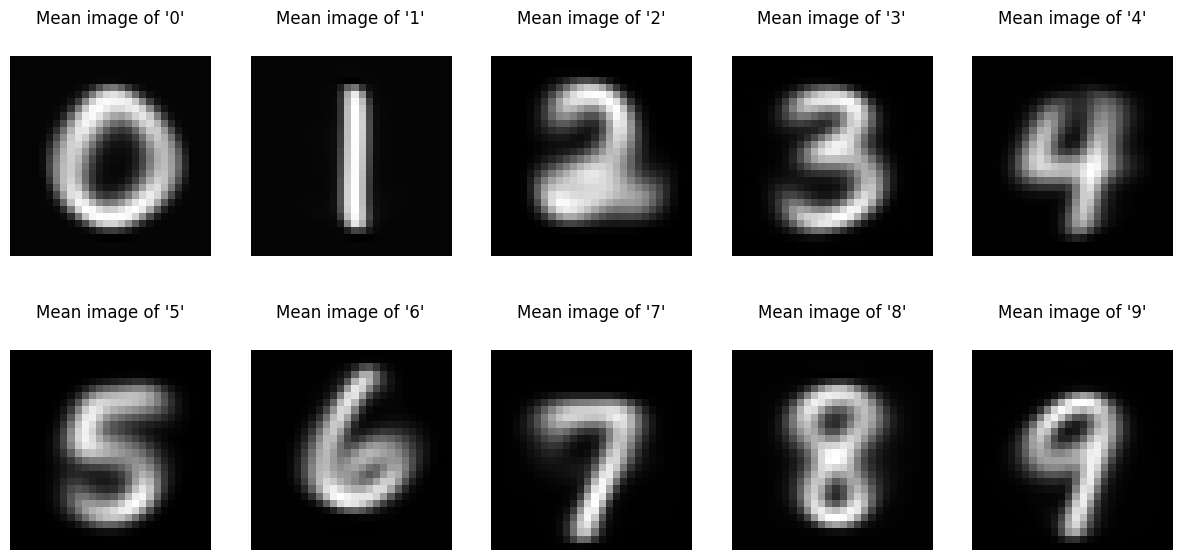

In [ ]:
fig, axs = plt.subplots(2, 5, figsize = (15, 7))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(mean_images[i].reshape(28, 28))
    ax.axis('off')
    ax.set_title(f'Mean image of \'{i}\'')

fig.show()

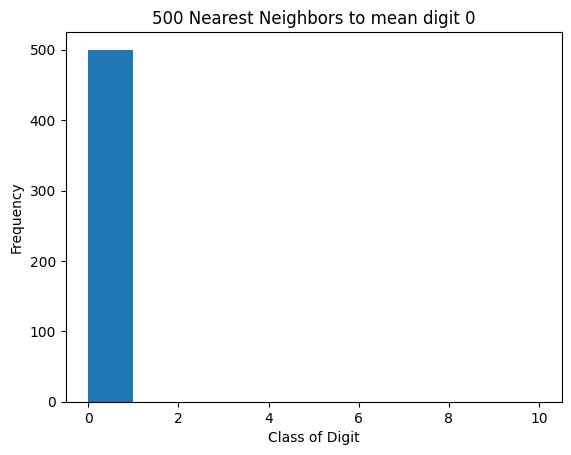

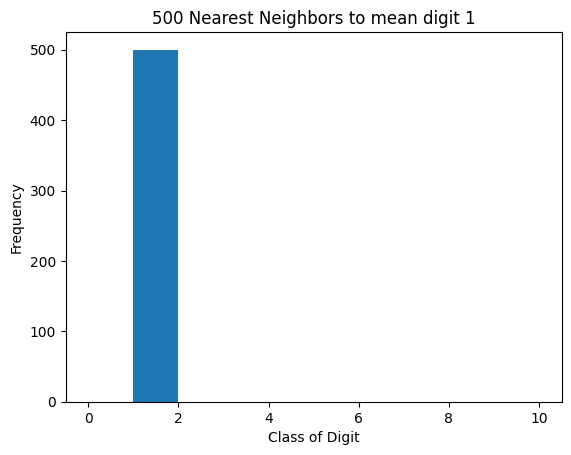

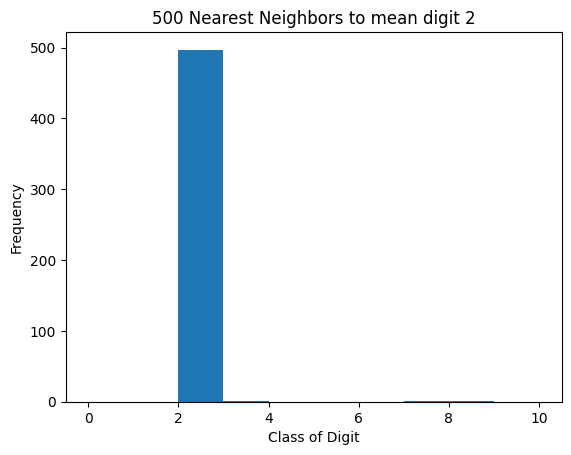

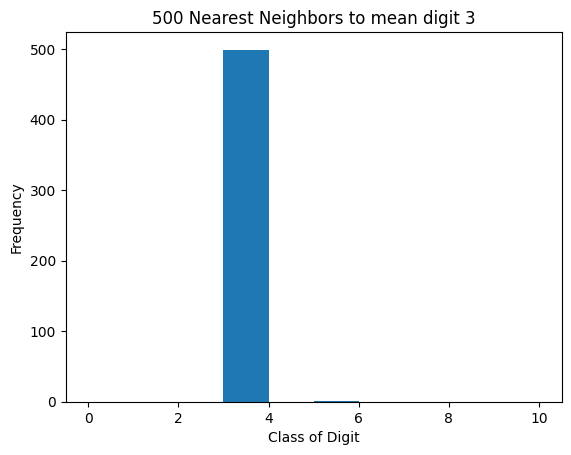

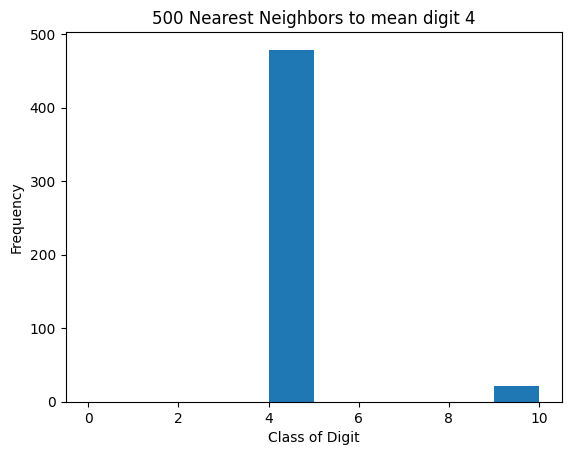

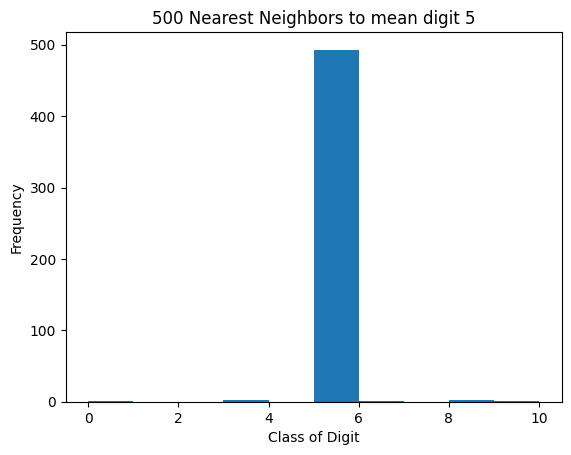

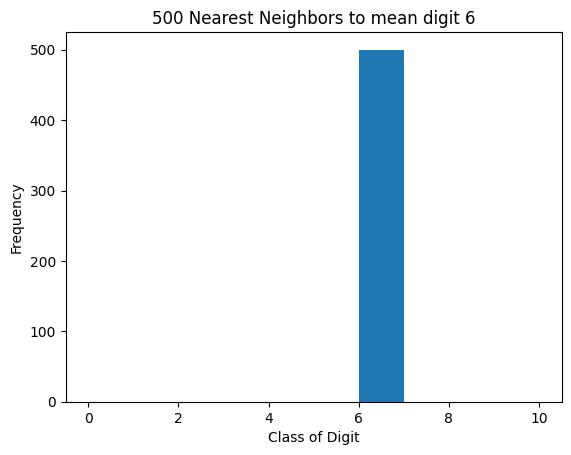

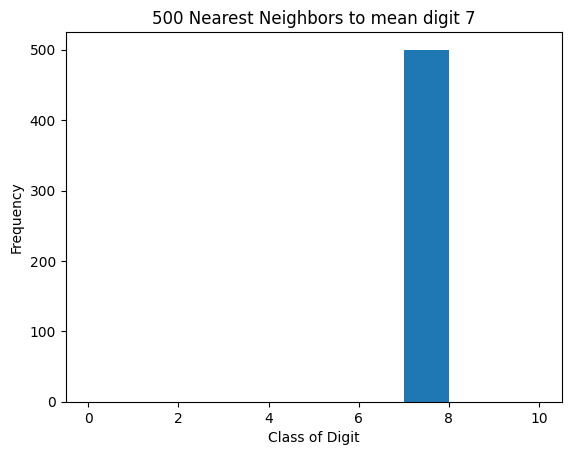

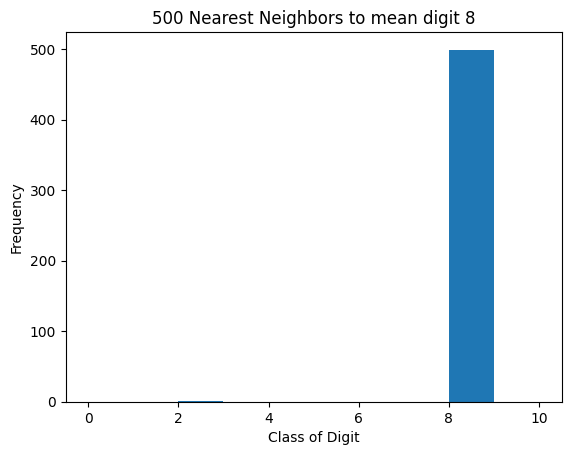

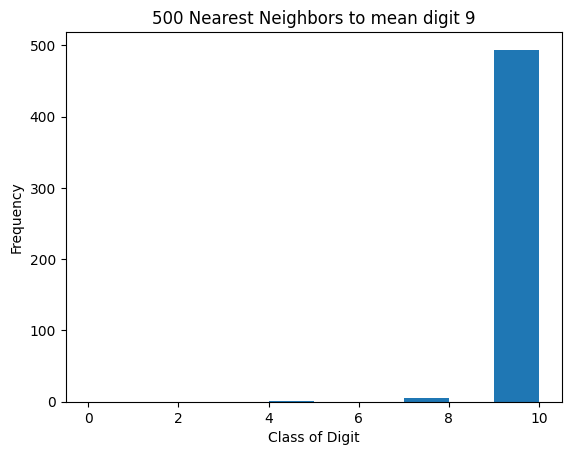

In [ ]:
for i in range(10):
  k_nearest_neighbors(mean_images[i], 500, graph=True)
  plt.title(f'500 Nearest Neighbors to mean digit {i}')
  plt.show()

The mean images of each class of digits in the MNIST training data are good representatives of their respective class. Hence, let's run an experiment to test how effective they would be when used for the classification of the MNIST test data.

In [ ]:
def compare_to_mean_image(image):
  distances = np.array([])

  for im in mean_images:
    distances = np.append(distances, np.linalg.norm(im-image))
  
  sorted_indices = np.argsort(distances)
  nearest_images = np.array(range(10))[sorted_indices]

  return nearest_images[0]

The function, compare_to_mean_image, is applying k-nearest neighbors with $k = 1$ and using the mean images as its training data.



In [ ]:
correct = 0

for index, image in enumerate(x_test):
  if y_test[index] == compare_to_mean_image(image):
    correct += 1
print(f'The percentage accuracy is : {(correct*100)/len(x_test)}%')

The percentage accuracy is : 86.94%


The mean images are good representatives of each class of digit but may not be good at differentiating outliers. However, the computation time is much faster than with the implemented KNN algorithm in the function k_nearest_neighbors which uses the entire MNIST training set as its training data. Having good representatives of all digits plus outliers would be a strong technique that would give us not only good results but also have a fast computation time.

We will use K-Means Clustering to try to better our results by creating clusters of other features in the data (e.g., the different ways people write a certain number).


###**K-Means Clustering**

In [ ]:
# k : (expects) a positive integer that represents the number of clusters desired
# outputs a KMeans object
def create_clusters(k):
  km = KMeans(n_clusters = k)
  km.fit(x_train) 
  return km

# km : KMeans object
# k : (expects) a positive integer that represents the number of clusters used for the instantiation of km
# outputs a dictionary with the inferred labels of each cluster
def id_clusters(km, k):
  actual_label = {}
  for i in range(k):
    act_lab = -1
    frequency = {}
    for j in y_train[km.labels_==i]:
      if j not in frequency:
        frequency[j] = 1
      else:
        frequency[j] += 1

    largest = -1
    number = -1
    for key, value in frequency.items():
      if value > largest:
        largest = value
        number = key
    actual_label[i] = number
  return actual_label

# image : a 784 dimensional vector
# nn : a positive integer that represents the number of nearest neighbors
# km : a KMeans object
# labels : the inferred labels of each cluster in km
# outputs the algorithm prediction (integer)
def knn_with_clusters(image, nn, km, labels):
  distances = np.array([])

  for im in km.cluster_centers_:
    distances = np.append(distances, np.linalg.norm(im-image))

  sorted_indices = np.argsort(distances)[:nn]
  nearest_images = np.array(range(len(km.cluster_centers_)))[sorted_indices]

  frequency = {}

  for l in nearest_images:
    if labels[l] not in frequency:
      frequency[labels[l]] = 1
    else:
      frequency[labels[l]] += 1

  largest = -1
  number = -1
  for key, value in frequency.items():
    if value > largest:
      largest = value
      number = key
  return number

In [ ]:
knum = range(10, 60, 10)
accuracy1 = []
for k in knum:
  km = create_clusters(k)
  labels = id_clusters(km, k)

  correct = 0
  for i in range(len(x_test)):
    if y_test[i] == knn_with_clusters(x_test[i], 1, km, labels):
      correct += 1
  accuracy1.append((correct*100)/len(x_test))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

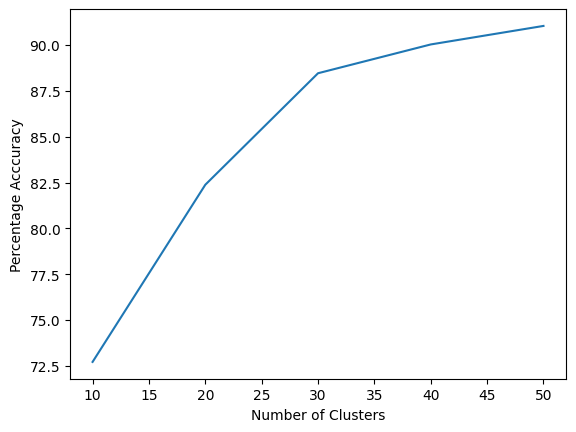

In [ ]:
plt.plot(knum, accuracy1)
plt.xlabel("Number of Clusters")
plt.ylabel("Percentage Acccuracy")
plt.show()

We can see that as the number of clusters increases the classification accuracy increases. This is as expected since more clusters mean more features (i.e., more centroids that represent different ways of writing certain digits). However, why is the accuracy so low when the number of clusters equals 10?

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


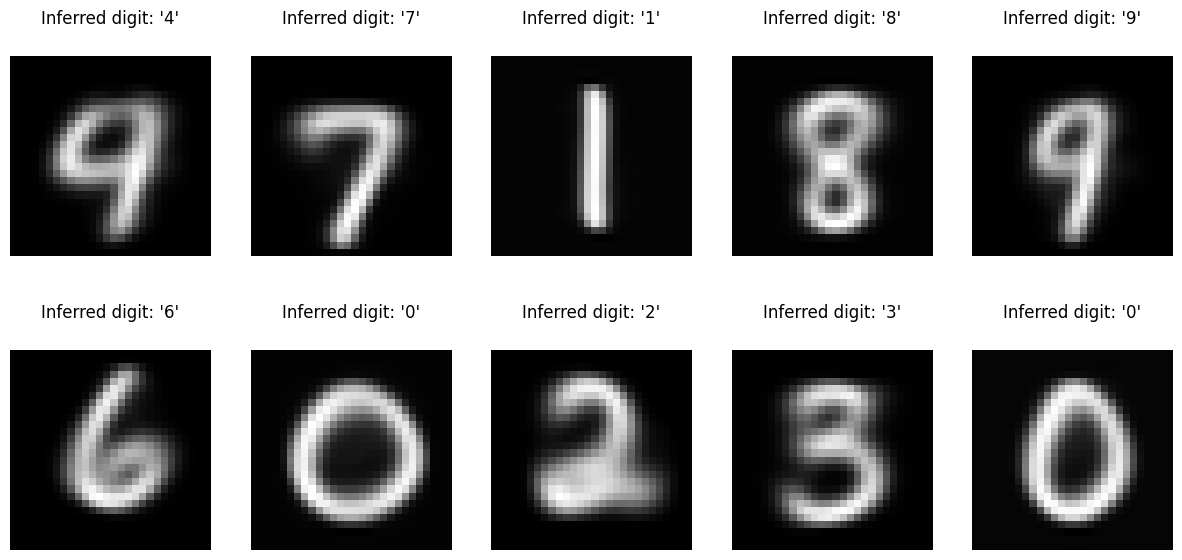

In [ ]:
clusters10 = create_clusters(10)
labels = id_clusters(clusters10, 10)

fig, axs = plt.subplots(2, 5, figsize = (15, 7))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(clusters10.cluster_centers_[i].reshape(28, 28))
    ax.axis('off')
    ax.set_title(f'Inferred digit: \'{labels[i]}\'')

fig.show()

We can see the 10 centroids generated by k-means. K-means is nondeterministic so the output changes each time that you run the algorithm but it is unlikely that all digits are represented when the number of clusters equals 10. A digit that is often overlook by the algorithm is 5 thus we would be unable to identify the digits 5 since they are missing from our training data. This is why the classification accuracy is low when running k-means with $k=10$.

We can also see that the method id_clusters(km, k) is working well since it was able to identify what digit was represented by each centroid.

In [ ]:
clusters50 = create_clusters(50)
labels = id_clusters(clusters50, 50)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
knum = range(1, 51, 2)
accuracy2 = []
for k in knum:
  correct = 0
  for i in range(len(x_test)):
    if y_test[i] == knn_with_clusters(x_test[i], k, clusters50, labels):
      correct += 1
  accuracy2.append((correct*100)/len(x_test))

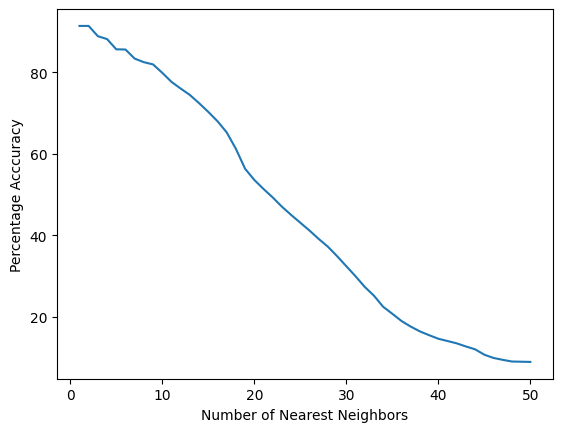

In [ ]:
plt.plot(knum, accuracy2)
plt.xlabel("Number of Nearest Neighbors")
plt.ylabel("Percentage Acccuracy")
plt.show()

As we increase the number of nearest neighbors the classification accuracy decreases. However, I would expect to see the percentage accuracy increasing and then decreasing when increasing the number of nearest neighbors if the clusters are distributed uniformly (i.e., the same number of clusters for each class of digit). Let's use t-SNE to visualize the clusters and see why this is happening.

###**Cluster Visualization using t-Distributed Stochastic Neighbor Embedding (t-SNE)**

We are going to use t-SNE to map the first 10,000 training images to points in $\mathbb{R}^2$.

In [ ]:
def plot_image_at_point(im, xy, zoom = 1):    
  dxy = np.random.rand(2)/100 * plt.ylim()
  plt.arrow(*xy, *dxy)
  ab = AnnotationBbox(OffsetImage(im, zoom=zoom, cmap = 'gray'), xy + dxy, frameon=False)
  plt.gca().add_artist(ab)

In [ ]:
num_iters = 300
perplexity = 10
my_random_state = 1236

tsne = TSNE(n_components = 2, n_iter = num_iters, perplexity = perplexity, random_state = my_random_state)

tsne.fit(x_train[:10000].reshape((10000, 784)))

x_reduced = tsne.embedding_

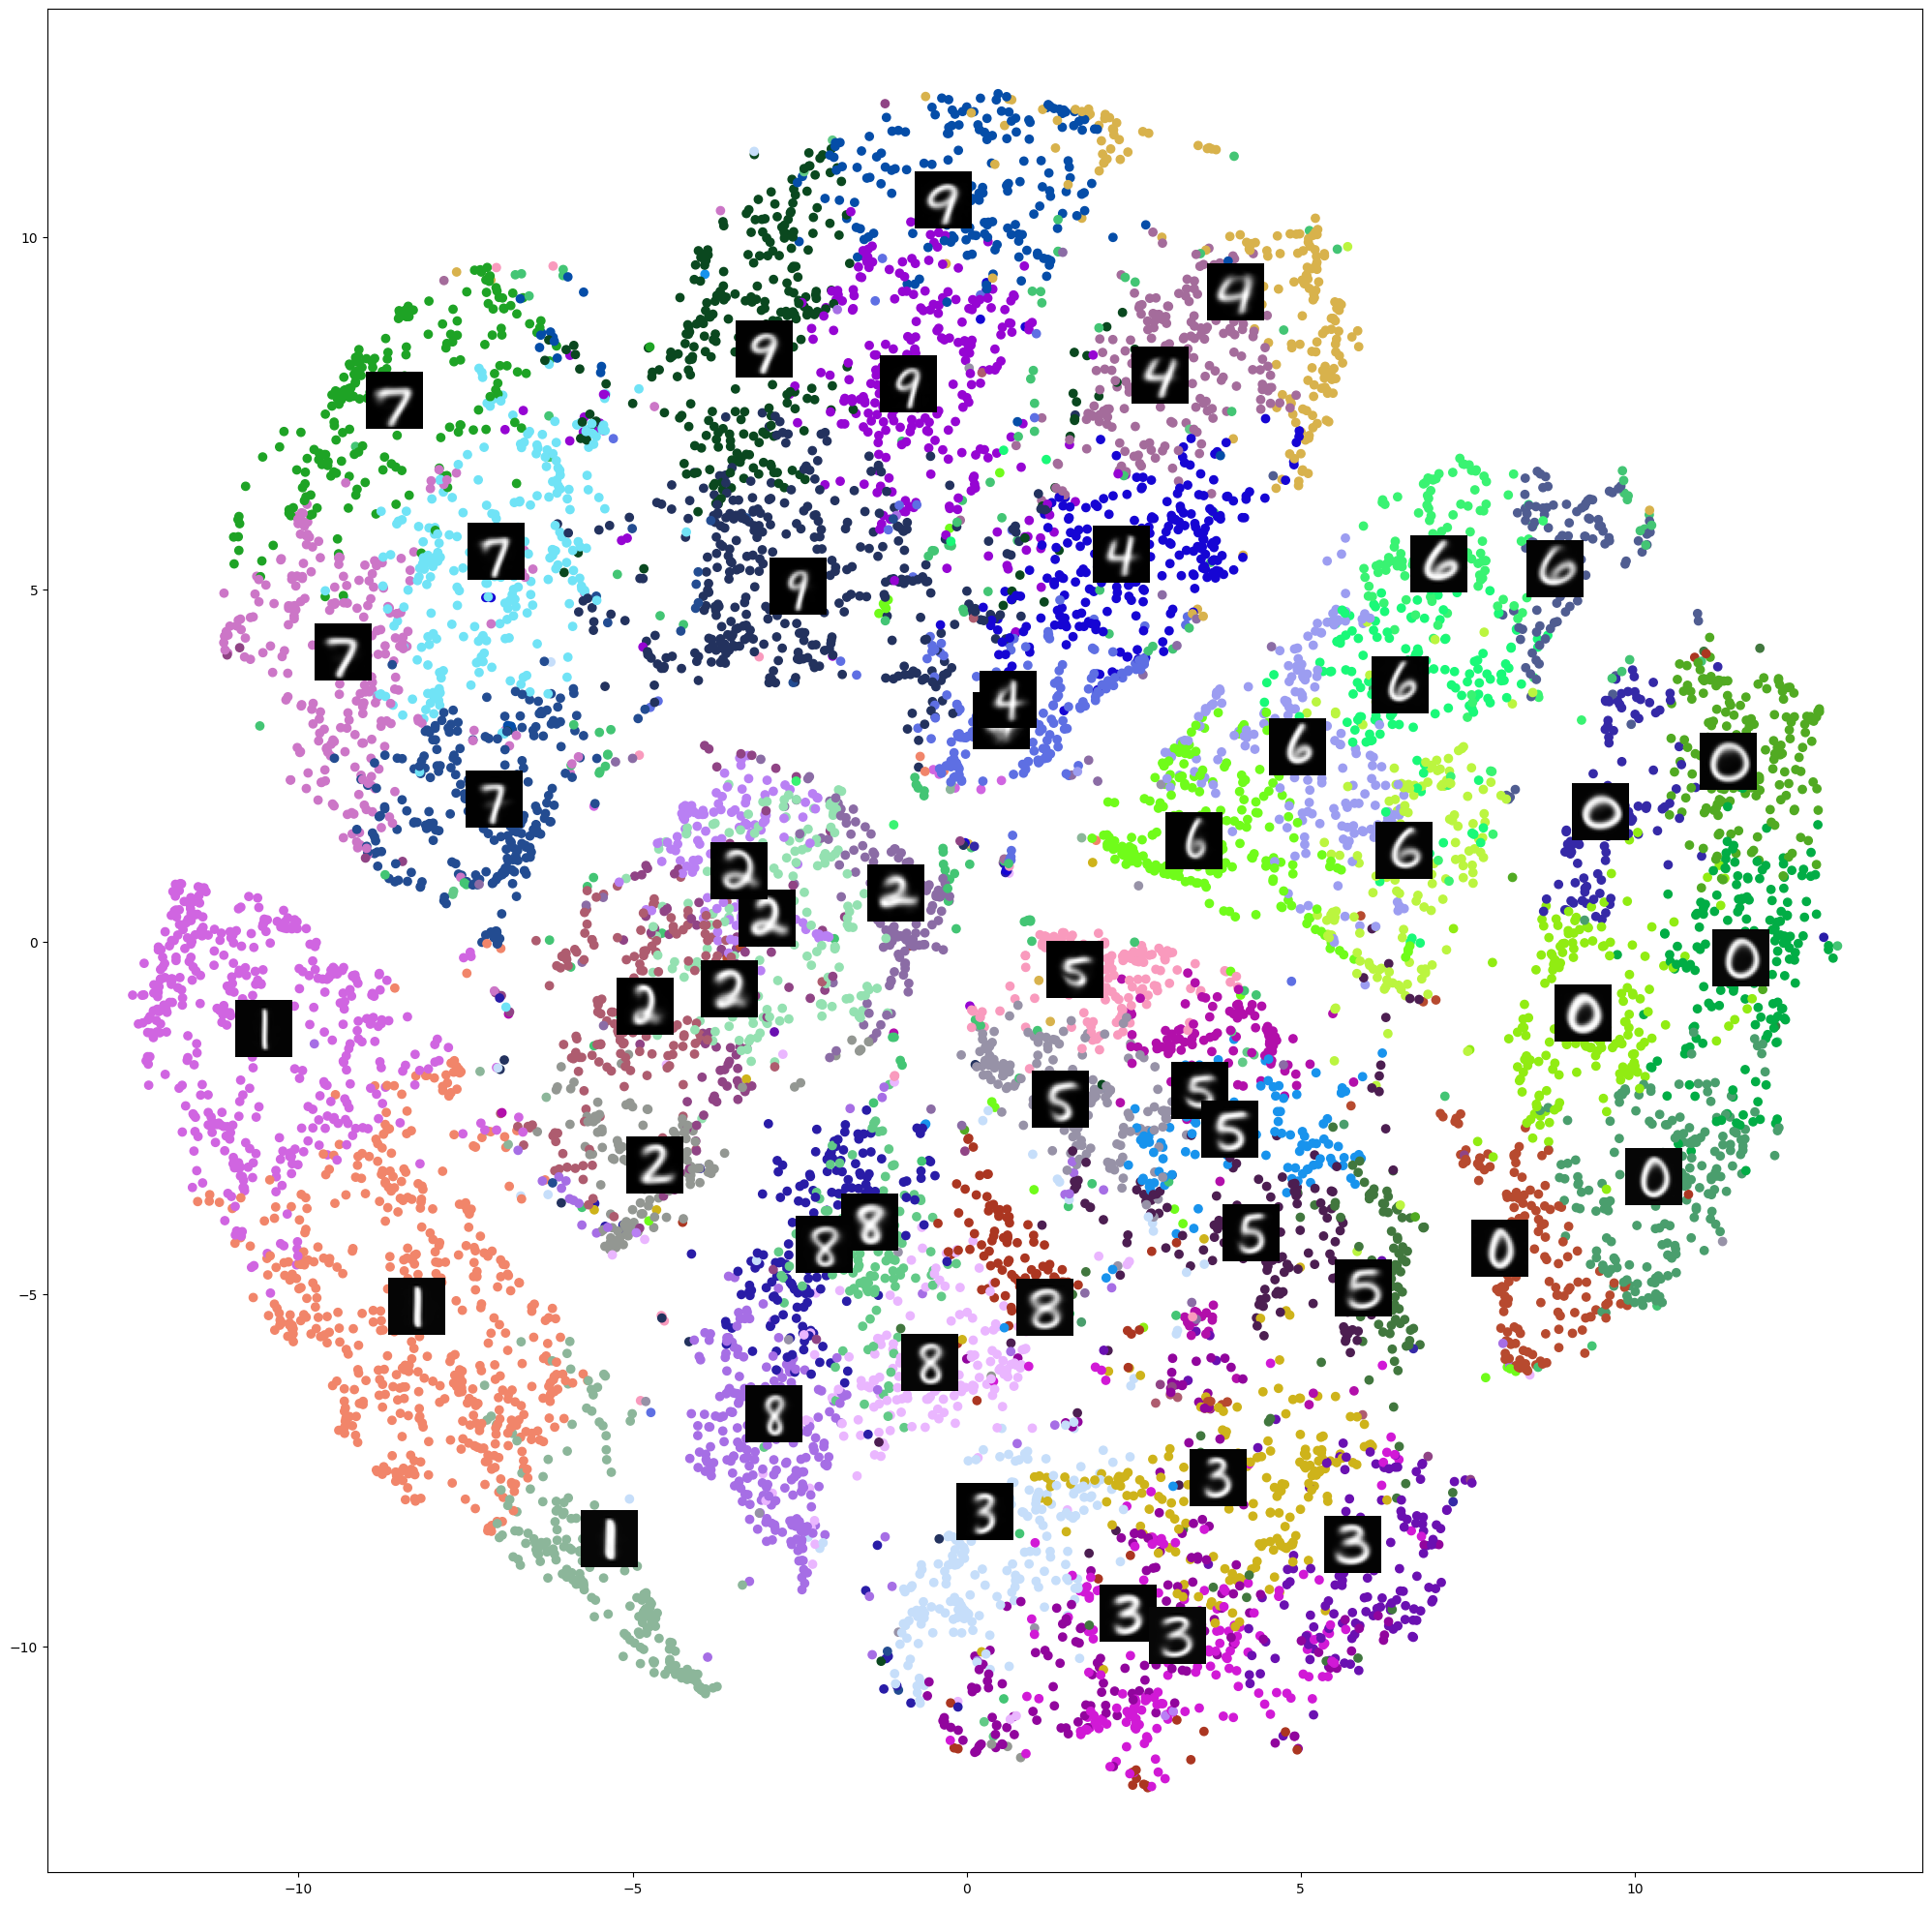

In [ ]:
np.random.seed(0)
plt.figure(figsize = (25,25))

label_colors = np.random.random((50, 3))

colors = label_colors[clusters50.labels_[:10000]]

plt.scatter(x_reduced.T[0], x_reduced.T[1], c = colors)

for i in range(50):
  plot_image_at_point(clusters50.cluster_centers_[i].reshape(28, 28), np.mean(x_reduced[clusters50.labels_[:10000]==i], axis=0), 1.5)

Thanks to t-SNE we can observe the 50 clusters and their respective centroids. The reason why the classification accuracy decreases as the number of nearest neighbors increases is that the classes of digits with a low number of clusters depicting them gets overshadowed by the other classes. For example, if the number of nearest neighbors is equal to 50 then it would be impossible for the algorithm to classify correctly a digit depicting the class 1.

###**Optical Character Recognition in Real Life Images**

<IPython.core.display.Javascript object>

Saved to number_image4.jpg


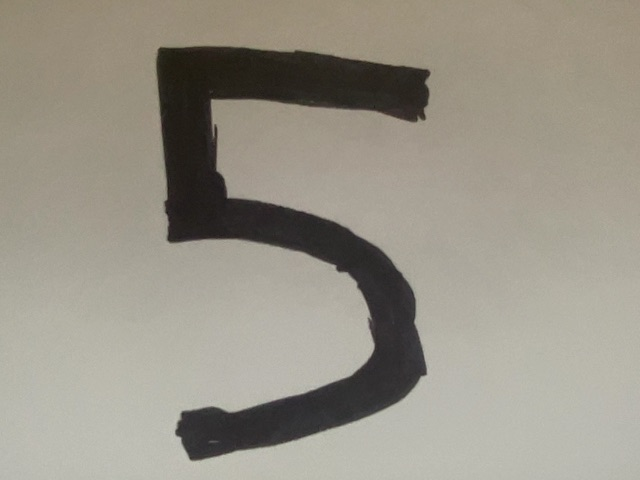

In [ ]:
#@title Code snippet
def take_photo(filename='number_image.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**Image Pre-processing**

<ipython-input-6-935e80f76932>:24: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  img = interpolation.affine_transform(image,affine,offset=offset)


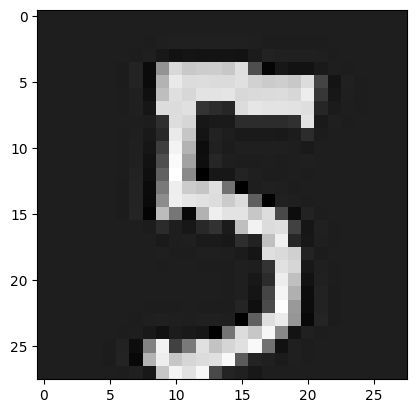

In [ ]:
original_image = cv2.imread(filename)
# converts the image to grayscale
processed_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# image binarization with 255 as its maximum value
processed_image = cv2.adaptiveThreshold(processed_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,199,10)
processed_image = processed_image / 255
# resizes the 640x480 image into a 28x28 image
processed_image = cv2.resize(processed_image, (28, 28), 0, 0, interpolation = cv2.INTER_NEAREST)
processed_image = deskew(processed_image)

plt.imshow(processed_image, cmap = 'gray')
plt.show()

processed_image = np.reshape(processed_image, (1,784))

**Image Classification using K-Nearest Neighbors with $k=11$ and with the entire MNIST training set as its training data**

In [ ]:
%time your_number = k_nearest_neighbors(processed_image, 11)

print()
print(f'The predicted value is : {your_number}')

CPU times: user 1.66 s, sys: 13.8 ms, total: 1.68 s
Wall time: 1.68 s

The predicted value is : 5


This is the slowest classification algorithm implemented, but may be one of the most accurate.

**Image Classification using K-Nearest Neighbors with $k=1$ and with the 10 mean images as its training data**

In [ ]:
%time your_number = compare_to_mean_image(processed_image)

print()
print(f'The predicted value is : {your_number}')

CPU times: user 448 µs, sys: 0 ns, total: 448 µs
Wall time: 457 µs

The predicted value is : 5


This is the fastest classification algorithm implemented, but may not be as accurate as the other two.

****Image Classification using K-Nearest Neighbors with $k=1$ and with the 50 centroids generated by k-means clustering as its training data****

In [ ]:
%time your_number = knn_with_clusters(processed_image, 1, clusters50, labels)

print()
print(f'The predicted value is : {your_number}')

CPU times: user 2.93 ms, sys: 0 ns, total: 2.93 ms
Wall time: 2.7 ms

The predicted value is : 5


This algorithm can be both fast and accurate.